# Trabajo Práctico N° 7: Procesamiento Morfológico

Desarrollar un aplicativo que permita abrir una imagen y automáticamente convertirla a niveles de grises (en caso de no estarlo) y visualizarla. Con esta imagen se aplicarán los siguientes filtros morfológicos, los cuales deben poderse seleccionar de una lista:
- Erosión (tomar el mínimo valor de luminancia de la vecindad)
- Dilatación (tomar el máximo valor de luminancia de la vecindad)
- Apertura
- Cierre
- Borde morfológico (frontera interna y externa)
- Mediana
- Top-hat

El elemento estructurante será de una ventana de 3x3 pixeles. El aplicativo debe incluir una función de copiado de la imagen procesada, de tal manera que esta pueda tomarse como imagen de entrada para así poder aplicar dos o más filtros en secuencia. El resultado del filtro debe poder guardarse como una nueva imagen en nivel de grises. Adicionalmente se debe mostrar un plot con el resultado respectivo para cada uno de los filtros indicados.


*Nota:* La función que desarrollaron para la convolución es la misma que pueden usar para recorrer toda la imagen y aplicar el filtro morfológico.

In [1]:
import numpy as np
import imageio
from matplotlib import pyplot as plt

#CONVERSION BETWEEN RGB AND YIQ SPACES
def RGBtoYIQ(img_rgb):
  coef = np.array([[   0.299,     0.587,     0.114],
                   [0.595716, -0.274453, -0.321263],
                   [0.211456, -0.522591,  0.311135]])
  
  img_norm = img_rgb / 255 #Normalization of RGB vector
  dims = img_rgb.shape
  img_yiq = np.zeros(dims)
  for i in range(dims[0]):
    for j in range(dims[1]):
      img_yiq[i, j, :] = np.matmul(coef, img_norm[i, j, :])
  np.clip(img_yiq[:,:,0],       0,      1, out=img_yiq[:,:,0])  #       0 <= Y <= 1
  np.clip(img_yiq[:,:,1], -0.5957, 0.5957, out=img_yiq[:,:,1])  # -0.5957 <= I <= 0.5957
  np.clip(img_yiq[:,:,2], -0.5226, 0.5226, out=img_yiq[:,:,2])  # -0.5226 <= Q <= 0.5226
  return img_yiq

def YIQtoRGB(img_yiq):
  coef = np.array([[1,  0.9663,  0.6210],
                   [1, -0.2721, -0.6474],
                   [1, -1.1070,  1.7046]])
  
  dims = img_yiq.shape
  img_norm_rgb = np.zeros(dims)
  for i in range(dims[0]):
    for j in range(dims[1]):
      img_norm_rgb[i, j, :] = np.matmul(coef, img_yiq[i, j, :])
  np.clip(img_norm_rgb, 0, 1, out=img_norm_rgb)
  return np.uint8(np.floor(img_norm_rgb * 255)) #De-normalization of normalized RGB vector

In [16]:
#EXPANSION BY PADDLING
def expand_edges(img, n):
    dim = img.shape
    new_img = np.zeros((dim[0] + 2 * n, dim[1] + 2 * n))
    if (len(dim) > 2):
      new_img[n:-n, n:-n] = img[:, :, 0]
    else:
      new_img[n:-n, n:-n] = img
    return new_img

#OPERADORES MORFOLOGICOS
def apply_morf_op(img, op_type):
  n = 1
  struct_elem = np.ones((3, 3))

  #GETTING LUMINANCE FROM IMAGE
  dims = img.shape
  if (len(dims) > 2):
    yiq_img = RGBtoYIQ(img)
    yiq_img[:, :, 1:] = 0 #CROMINANCE TO ZERO
    dims = (dims[0], dims[1])
  else:
    yiq_img = np.zeros((dims[0], dims[1], 3))
    yiq_img[:, :, 0] = img / 255
  
  proc_img = yiq_img[:, :, 0] #LUMINANCE
  
  
  def dilation(img):
    #PADDLING IMAGE
    expanded_img = expand_edges(img, n)
    #DILATION
    dilated_img = np.zeros(dims)
    for (i, j), v in np.ndenumerate(expanded_img[n:-n, n:-n]):
      dilated_img[i, j] = np.max(expanded_img[i : i + (2 * n + 1), j : j + (2 * n + 1)] * struct_elem)
    return dilated_img
  
  def erosion(img):
    #PADDLING IMAGE
    expanded_img = expand_edges(img, n)
    #EROSION
    eroded_img = np.zeros(dims)
    for (i, j), v in np.ndenumerate(expanded_img[n:-n, n:-n]):
      eroded_img[i, j] = np.min(expanded_img[i : i + (2 * n + 1), j : j + (2 * n + 1)] * struct_elem)
    return eroded_img
  
  def median(img):
    #PADDLING IMAGE
    expanded_img = expand_edges(img, n)
    #EROSION
    mid_img = np.zeros(dims)
    for (i, j), v in np.ndenumerate(expanded_img[n:-n, n:-n]):
      mid_img[i, j] = np.median(expanded_img[i : i + (2 * n + 1), j : j + (2 * n + 1)])
    return mid_img
  
  
  #IMAGE PROCESSING OVER LUMINANCE
  if op_type == 'Dilatacion':
    yiq_img[:, :, 0] = dilation(proc_img)
  elif op_type == 'Erosion':
    yiq_img[:, :, 0] = erosion(proc_img)
  elif op_type == 'Apertura':
    yiq_img[:, :, 0] = dilation(erosion(proc_img))
  elif op_type == 'Cierre':
    yiq_img[:, :, 0] = erosion(dilation(proc_img))
  elif op_type == 'Borde interior':
    yiq_img[:, :, 0] = proc_img - erosion(proc_img) 
  elif op_type == 'Borde exterior':
    yiq_img[:, :, 0] = dilation(proc_img) - proc_img
  elif op_type == 'Gradiente':
    yiq_img[:, :, 0] = dilation(proc_img) - erosion(proc_img)
  elif op_type == 'Mediana':
    yiq_img[:, :, 0] = median(proc_img)
  elif op_type == 'Top hat':
    yiq_img[:, :, 0] = proc_img - dilation(erosion(proc_img))


  return YIQtoRGB(np.clip(yiq_img, 0., 1.))



Dejo aquí en comentarios los títulos de las imágenes que mejor mostraron el efecto producido por las operaciones morfológicas.

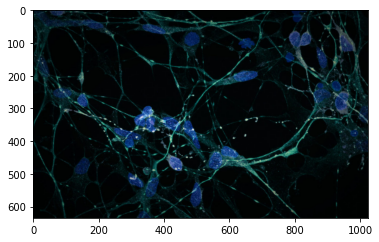

In [14]:
URL = 'cells.png' #Dilatacion, Erosion, borde interior y exterior
#URL = 'building.jfif' #Apertura, Cierre
#URL = 'woman_umbrella.jpg' #Borde interior, exterior y gradiente
#URL = 'marmol.jfif' #Top hat
img = imageio.imread(URL)

plt.set_cmap('gray')
plt.imshow(img)
restart_option = True 

In [19]:
restart_option = True

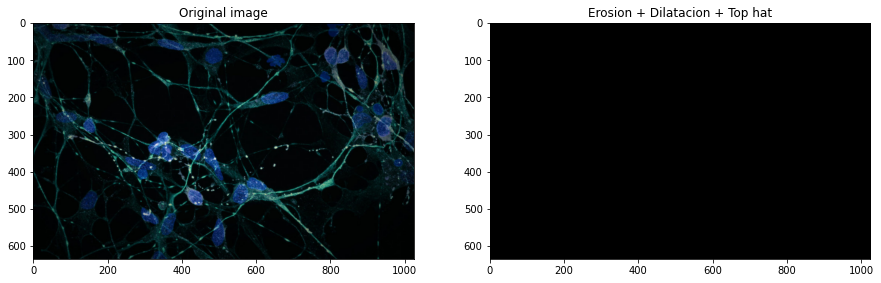

In [22]:
#@title Pick a filter

op_type = 'Top hat' #@param ['Dilatacion', 'Erosion', 'Apertura', 'Cierre', 'Borde interior', 'Borde exterior', 'Gradiente', 'Mediana', 'Top hat']

if (restart_option == True):
  #IMAGE PROCESSING
  new_img = apply_morf_op(img, op_type)
  restart_option = False 
  morph_title = op_type
else:
  #IMAGE PROCESSING
  new_img = apply_morf_op(new_img, op_type)
  morph_title += ' + ' + op_type

#PLOTTING
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(img)
ax[0].set_title('Original image')

ax[1].imshow(new_img)
ax[1].set_title(morph_title)
plt.show()

In [ ]:
#SAVE IMAGE
img_name = "img_borde_interior" #@param {type:"string"}
imageio.imwrite(img_name, new_img, 'png')